In [1]:
print("Importing necessary libraries...", end =" ")
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import time
import datetime
import matplotlib.image as mpimg
import cv2
import gc
import psutil
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.corpus import wordnet as wn

import pandas as pd
import io
import numpy as np
import os

from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn import metrics
from sklearn import utils
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional, SimpleRNN 
from keras.utils import to_categorical
from keras.regularizers import l2

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, SimpleRNN, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from collections import defaultdict

from __future__ import absolute_import, division, print_function

from joblib import Parallel, delayed
print("done!")

start = datetime.datetime.now()

Importing necessary libraries... done!


# Enron

In [2]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

target_numbers = {'Positive': 7000, 'Neutral': 7000, 'Negative': 7000}

outputDir = 'C:\\Users\\Owner\\OneDrive\\Desktop\\My Computer\\AI\\Master of Science in Artificial Intelligence [Taught and Research (Mainly by Research)]\\ICS5200 Dissertation\\Result Screenshots\\Subplots\\'

# Enron
print("Importing Enron dataset...", end =" "),
data = pd.read_csv("./Datasets/emails.csv")
print("done!")

# Number of rows to drop
n = 400000

print("Removing extra ", n, "rows from Enron dataset...", end =" "),
# Dropping last n rows using drop
data.drop(data.tail(n).index,
        inplace = True)
print("done!")

# data.count()

Importing Enron dataset... done!
Removing extra  400000 rows from Enron dataset... done!


In [3]:
%%time

def clean_email_text(email_text):
    pattern = r"Message-ID.*Content-Transfer-Encoding: 7bit"
    email_text = re.sub(pattern, "", email_text, flags=re.DOTALL)
    lines = email_text.split("\n")
    res = []
    for line in lines:
        if "X-" not in line:
            line.replace("\t"," ")
            res.append(line)
    return " ".join(res)


def replace_empty_string_with_Null(text):
    if text == "":
        return None
    return text


def remove_punctuations_and_special_characters(text):
    return re.sub(r'[^\w\s]','',text)


def preprocessing_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)


def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']


# Text preprocessing
print("Preprocessing Enron text...", end =" "),
data["processed_message"] = data['message'].apply(clean_email_text)
data.processed_message = data.processed_message.apply(replace_empty_string_with_Null)
null_values = data.processed_message.isnull()
data.dropna(subset=['processed_message'], inplace = True)
data.processed_message = data.processed_message.apply(lambda x: remove_punctuations_and_special_characters(x))
data.processed_message = data.processed_message.apply(preprocessing_text)
print("done!")

#Sentiment labelling
print("Labelling the text with sentiments using the VADER Sentiment Analyzer...", end =" "),
data["vader_intensity"] = data["processed_message"].apply(get_vader_sentiment)
print("done!")

# Sentiment mapping
print("Mapping sentiment values...", end =" "),
data["vader_sentiment"] = data["vader_intensity"].apply(lambda x: "Positive" if x>0 else "Negative" if x<0 else "Neutral")
print("done!")

# Compiling dataset.
print("Compiling final dataset...", end =" "),
data = data[['processed_message', 'vader_sentiment']]
print("done!")

print()

difference = 7000
# difference = 9000

# Calculating extra rows to be removed.
posDiff = (data[data.vader_sentiment == 'Positive'].shape[0]) - difference
negDiff = (data[data.vader_sentiment == 'Negative'].shape[0]) - difference
neuDiff = (data[data.vader_sentiment == 'Neutral'].shape[0]) - difference

print("Rows to be removed from Enron dataset:")
print("Enron Neutral Sentiment entries : ", data[data.vader_sentiment == 'Neutral'].shape[0], " rows, with ", neuDiff, " rows to remove.")
print("Enron Positive Sentiment entries: ", data[data.vader_sentiment == 'Positive'].shape[0], "rows, with ", posDiff, " rows to remove.")
print("Enron Negative Sentiment entries: ", data[data.vader_sentiment == 'Negative'].shape[0], "rows, with ", negDiff, " rows to remove.")

print()

# Removing extra rows to end up with a dataset containing equal sentiment distribution.
data = data.drop(data[data['vader_sentiment'] == 'Neutral'].sample(n=neuDiff, random_state=42).index)
data = data.drop(data[data['vader_sentiment'] == 'Positive'].sample(n=posDiff, random_state=42).index)
data = data.drop(data[data['vader_sentiment'] == 'Negative'].sample(n=negDiff, random_state=42).index)

print("Updated Enron Neutral Sentiment entries : ", data[data.vader_sentiment == 'Neutral'].shape[0])
print("Updated Enron Positive Sentiment entries: ", data[data.vader_sentiment == 'Positive'].shape[0])
print("Updated Enron Negative Sentiment entries: ", data[data.vader_sentiment == 'Negative'].shape[0])

Preprocessing Enron text... done!
Labelling the text with sentiments using the VADER Sentiment Analyzer... done!
Mapping sentiment values... done!
Compiling final dataset... done!

Rows to be removed from Enron dataset:
Enron Neutral Sentiment entries :  12567  rows, with  5567  rows to remove.
Enron Positive Sentiment entries:  95256 rows, with  88256  rows to remove.
Enron Negative Sentiment entries:  9576 rows, with  2576  rows to remove.

Updated Enron Neutral Sentiment entries :  7000
Updated Enron Positive Sentiment entries:  7000
Updated Enron Negative Sentiment entries:  7000
CPU times: total: 4min 15s
Wall time: 9min 5s


In [4]:
%%time

X = data['processed_message']
y = data['vader_sentiment']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
print("Splitting data into train and test sets...", end = " ")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print("done!")

# Vectorize the text data
print("Vectorizing text data...", end = " ")
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print("done!")

Splitting data into train and test sets... done!
Vectorizing text data... done!
CPU times: total: 953 ms
Wall time: 2.04 s


In [5]:
%%time

# Machine Learning Models
print("Initializing machine learning models...", end = " ")
svm_model = SVC(probability=True)
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=200)
dt_model = DecisionTreeClassifier()
print("done!")


# Combine ML models using VotingClassifier
print("Combining ML models using VotingClassifier...", end = " ")
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('nb', nb_model),
    ('lr', lr_model),
    ('dt', dt_model)
], voting='soft')
print("done!")


# Train each model sequentially
print("Training SVM model...", end = " ")
svm_model.fit(X_train_vec, y_train)
print("done!")

print("Training Naive Bayes model...", end = " ")
nb_model.fit(X_train_vec, y_train)
print("done!")

print("Training Logistic Regression model...", end = " ")
lr_model.fit(X_train_vec, y_train)
print("done!")

print("Training Decision Tree model...", end = " ")
dt_model.fit(X_train_vec, y_train)
print("done!")

print("Fitting the VotingClassifier with trained models...", end = " ")
# Fit the VotingClassifier with trained models
voting_clf.estimators_ = [('svm', svm_model), ('nb', nb_model), ('lr', lr_model), ('dt', dt_model)]
voting_clf.fit(X_train_vec, y_train)
print("done!")

# Predictions from VotingClassifier
print("Making predictions with the VotingClassifier...", end = " ")
ml_preds = voting_clf.predict_proba(X_test_vec)
print("done!")

Initializing machine learning models... done!
Combining ML models using VotingClassifier... done!
Training SVM model... done!
Training Naive Bayes model... done!
Training Logistic Regression model... 

D:\Anaconda Download\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


done!
Training Decision Tree model... done!
Fitting the VotingClassifier with trained models... 

D:\Anaconda Download\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


done!
Making predictions with the VotingClassifier... done!
CPU times: total: 6min 26s
Wall time: 15min 7s


In [6]:
%%time

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

# Reshape data for LSTM
max_features = X_train_vec.shape[1]
maxlen = X_train_vec.shape[0]

X_train_lstm = X_train_vec.reshape(maxlen, 1, max_features)
X_test_lstm = X_test_vec.reshape(X_test_vec.shape[0], 1, max_features)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Best layers so far.
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, max_features))),
lstm_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
lstm_model.add(Dropout(0.4)),
lstm_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
lstm_model.add(Dropout(0.4)),
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_model.fit(X_train_lstm, y_train_onehot, batch_size=100, epochs=10, validation_split=0.1, callbacks=[early_stopping])

print("Predicting with LSTM model...", end = " ")
# Reshape the encoded texts for LSTM input
lstm_preds = lstm_model.predict(X_test_lstm).argmax(axis=1)  # Get the class with highest probability
print("done!")

class_report = classification_report(y_test, lstm_preds, target_names=label_encoder.classes_)
print(class_report)

D:\Anaconda Download\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │      31,708,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,715,267 (120.98 MB)

 Trainable params: 31,715,267 (120.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.4685 - loss: 1.4811 - val_accuracy: 0.8304 - val_loss: 0.6541
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8854 - loss: 0.5144 - val_accuracy: 0.8827 - val_loss: 0.4068
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9725 - loss: 0.2291 - val_accuracy: 0.8917 - val_loss: 0.3715
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9859 - loss: 0.1611 - val_accuracy: 0.8935 - val_loss: 0.3825
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9915 - loss: 0.1259 - val_accuracy: 0.8929 - val_loss: 0.3789
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9941 - loss: 0.1063 - val_accuracy: 0.8952 - val_loss: 0.3866
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
done!
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      1429
     Neutral       0.92      0.94      0.93      1358
   

In [7]:
%%time

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=4000)
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

ann_model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ann_model.fit(X_train_vec, y_train, epochs=20, batch_size=100, validation_split=0.1, verbose=1)

print("Predicting with ANN model...", end = " ")
ann_preds = ann_model.predict(X_test_vec).argmax(axis=1)
print("done!")

class_report = classification_report(y_test, ann_preds, target_names=label_encoder.classes_)
print(class_report)

D:\Anaconda Download\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │       1,024,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,065,603 (4.06 MB)

 Trainable params: 1,065,603 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5656 - loss: 2.2621 - val_accuracy: 0.8250 - val_loss: 0.8171
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8318 - loss: 0.8080 - val_accuracy: 0.8321 - val_loss: 0.7702
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8515 - loss: 0.7480 - val_accuracy: 0.8548 - val_loss: 0.7279
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8737 - loss: 0.6893 - val_accuracy: 0.8548 - val_loss: 0.6741
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8805 - loss: 0.6540 - val_accuracy: 0.8625 - val_loss: 0.6810
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8892 - loss: 0.6341 - val_accuracy: 0.8702 - val_loss: 0.6527
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8916 - loss: 0.6098 - val_accuracy: 0.8744 - val_loss: 0.6390
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9027 - loss: 0.5847 - val_accu

Combining predictions... done!
              precision    recall  f1-score   support

    Negative       0.95      0.83      0.88      1429
     Neutral       0.77      0.97      0.86      1358
    Positive       0.96      0.84      0.89      1413

    accuracy                           0.88      4200
   macro avg       0.89      0.88      0.88      4200
weighted avg       0.89      0.88      0.88      4200

CPU Load     :  2.0
RAM Used (GB): 20.185858048


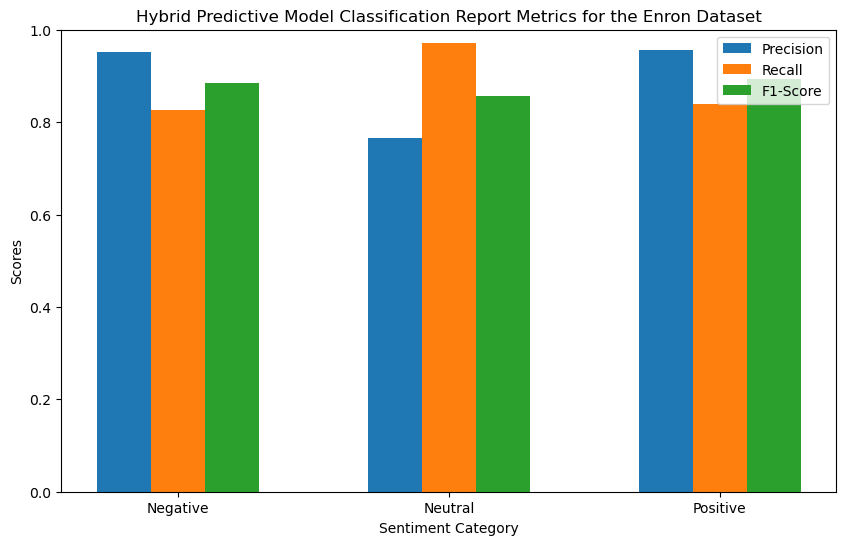

done!

Total program execution time: 0:27:57.946938
CPU times: total: 156 ms
Wall time: 2.14 s


4876

In [8]:
%%time

print("Combining predictions...", end = " ")
final_preds = []
for i in range(len(y_test)):
    combined_pred = (ml_preds[i].argmax() + lstm_preds[i] + ann_preds[i]) / 3
    final_preds.append(np.round(combined_pred).astype(int))

final_preds = np.array(final_preds)
print("done!")

# Generate the classification report
class_report = classification_report(y_test, final_preds, target_names=label_encoder.classes_)
print(class_report)

print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_preds, average=None)

# Plot precision, recall, and F1-score in a bar chart
labels = label_encoder.classes_

x = range(len(labels))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, precision, width=bar_width, label='Precision', align='center')
plt.bar([p + bar_width for p in x], recall, width=bar_width, label='Recall', align='center')
plt.bar([p + bar_width * 2 for p in x], f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Hybrid Predictive Model Classification Report Metrics for the Enron Dataset')
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.0)
plt.legend()

plt.savefig(outputDir + '\\Hybrid\\HybridModelEnron.png')

plt.show()
print("done!")

# Execution time
end = datetime.datetime.now()
duration = end - start
print("\nTotal program execution time:", duration)

# Garbage collection
gc.collect()